# Baseline tests

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import time
import psutil
from pathlib import Path
import openvino as ov
from ultralytics import YOLO

## Загрузим и экспортируем модель YOLOv8n в формат OpenVINO

In [8]:
# Загружаем предобученную YOLOv8n и экспортируем её в OpenVINO
model = YOLO('yolov8n.pt')
model.export(format='openvino', imgsz=640)

 Download failure, retrying 1/3 https://github.com/ultralytics/assets/releases/download/v8.2.0/yolov8n.pt...
Ultralytics YOLOv8.2.78  Python-3.12.2 torch-2.4.0+cpu CPU (AMD Ryzen 7 5700X 8-Core Processor)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

OpenVINO: starting export with openvino 2024.6.0-17404-4c0f47d2335-releases/2024/6...
OpenVINO: export success  3.1s, saved as 'yolov8n_openvino_model\' (12.3 MB)

Export complete (5.5s)
Results saved to B:\Python projects\inno\Methodology\Methodology_Article
Predict:         yolo predict task=detect model=yolov8n_openvino_model imgsz=640  
Validate:        yolo val task=detect model=yolov8n_openvino_model imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


'yolov8n_openvino_model'

In [ ]:
core = ov.Core()
model_path = 'yolov8n_openvino_model/yolov8n.xml'
compiled_model = core.compile_model(model_path, 'CPU')
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

## Создадим функции для предобработки и постобработки кадра

In [10]:
def preprocess(frame, input_size=640):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    scale = min(input_size / w, input_size / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img, (new_w, new_h))
    canvas = np.full((input_size, input_size, 3), 114, dtype=np.uint8)
    canvas[:new_h, :new_w] = resized
    # Нормализация и изменение формы: (1, 3, 640, 640)
    input_tensor = canvas.transpose(2, 0, 1).astype(np.float32) / 255.0
    input_tensor = input_tensor[None, ...]
    return input_tensor, scale, (w, h)

In [11]:
def postprocess(output, conf_threshold=0.5, img_shape=(640,640), original_shape=(640,480)):
    # output shape: (1, 84, 8400)
    predictions = output[0].transpose(1, 0)
    boxes = []
    person_detected = False
    
    for pred in predictions:
        confidence = pred[4]  
        class_scores = pred[4:]
        class_id = np.argmax(class_scores)
        score = class_scores[class_id]
        if score < conf_threshold:
            continue
            
        # Координаты относительно 640
        x, y, w, h = pred[:4]
        x1 = (x - w/2) / 640 * original_shape[0]
        y1 = (y - h/2) / 640 * original_shape[1]
        x2 = (x + w/2) / 640 * original_shape[0]
        y2 = (y + h/2) / 640 * original_shape[1]
        boxes.append([x1, y1, x2, y2, score, class_id])
        if class_id == 0:
            person_detected = True
    return boxes, person_detected

## Загрузка одного видео

In [57]:
# Загрузим видео с полным комнатным светом без естесвенного света
video_path = 'videos/fulllight.mp4'
cap = cv2.VideoCapture(video_path)
fps_video = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Видео: {video_path}, FPS: {fps_video}, всего кадров: {total_frames}")

Видео: videos/fulllight.mp4, FPS: 24.0, всего кадров: 1070


## Обработка видео

In [46]:
results = []

# Для подсчёта TTL нам нужно отслеживать серии пропусков
person_present = False
loss_counter = 0
loss_series = []

with tqdm(total=total_frames, desc="Обработка кадров") as pbar:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        start_time = time.perf_counter()
        
        # Предобработка
        input_tensor, scale, orig_size = preprocess(frame)
        
        # Инференс
        result = compiled_model([input_tensor])[output_layer]
        
        # Постобработка
        boxes, person_now = postprocess(result, img_shape=(640,640), original_shape=orig_size)
        
        end_time = time.perf_counter()
        inference_time = end_time - start_time  # секунды
        
        # Логика TTL
        if not person_now:
            loss_counter += 1
        else:
            if loss_counter > 0:
                loss_series.append(loss_counter)
                loss_counter = 0
        
        # Сохраняем данные кадра
        results.append({
            'frame': int(cap.get(cv2.CAP_PROP_POS_FRAMES)),
            'time_sec': cap.get(cv2.CAP_PROP_POS_MSEC) / 1000,
            'inference_time': inference_time,
            'person_detected': person_now,
            'num_detections': len(boxes)
        })
        
        pbar.update(1)

cap.release()

Обработка кадров:   0%|          | 0/1070 [00:00<?, ?it/s]

# Результаты

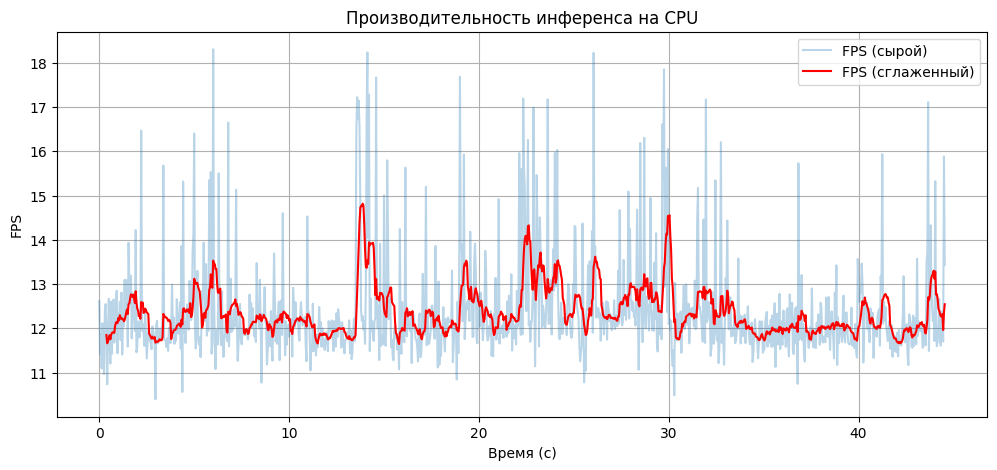

In [47]:
df = pd.DataFrame(results)
# FPS = 1 / inference_time
df['fps'] = 1 / df['inference_time']

# Скользящее среднее FPS для сглаживания
df['fps_smooth'] = df['fps'].rolling(window=10).mean()

# График FPS по времени
plt.figure(figsize=(12,5))
plt.plot(df['time_sec'], df['fps'], alpha=0.3, label='FPS (сырой)')
plt.plot(df['time_sec'], df['fps_smooth'], 'r-', label='FPS (сглаженный)')
plt.xlabel('Время (с)')
plt.ylabel('FPS')
plt.title('Производительность инференса на CPU')
plt.legend()
plt.grid(True)
plt.savefig('fps_plot.png')
plt.show()

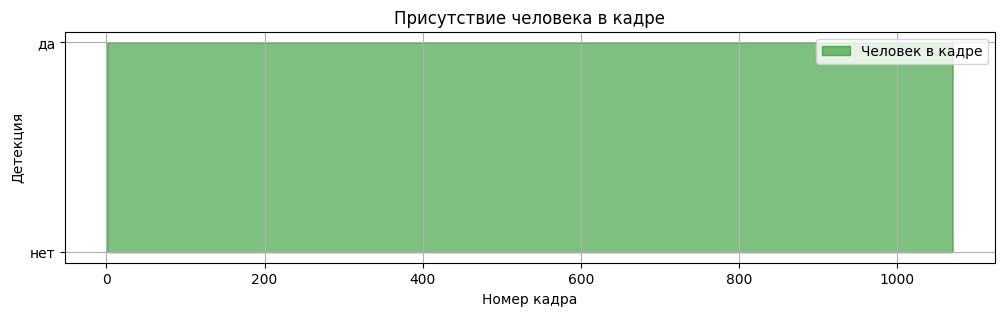

In [56]:
plt.figure(figsize=(12,3))
plt.fill_between(df['frame'], 0, df['person_detected'], color='green', alpha=0.5, label='Человек в кадре')
plt.xlabel('Номер кадра')
plt.ylabel('Детекция')
plt.yticks([0,1], ['нет','да'])
plt.title('Присутствие человека в кадре')
plt.legend()
plt.grid(True)
plt.savefig('presence_plot_frames.png')
plt.show()

In [49]:
if loss_series:
    loss_series = np.array(loss_series)
    print(f"Серий потери цели: {len(loss_series)}")
    print(f"Средняя длина серии (кадров): {loss_series.mean():.2f}")
    print(f"Максимальная длина серии (кадров): {loss_series.max()}")
    print(f"Медианная длина серии (кадров): {np.median(loss_series):.2f}")

    plt.figure(figsize=(10,5))
    plt.hist(loss_series, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Длительность потери (кадров)')
    plt.ylabel('Частота')
    plt.title('Распределение длительностей потери цели (TTL)')
    plt.grid(True)
    plt.savefig('ttl_hist.png')
    plt.show()
else:
    print("Потерь цели не было.")

Потерь цели не было.
